In [1]:
from pyspark.sql import SparkSession

# Create a SparkSession

spark = SparkSession.builder \
    .appName("Amazon Review Spam Detection") \
    .config("spark.executor.memory", "10g") \
    .config("spark.executor.memoryOverhead", "10g") \
    .config("spark.driver.memory", "10g") \
    .config("spark.default.parallelism", 200) \
    .getOrCreate()


# Load the JSON dataset
df = spark.read.json("Electronics.json")
# Show the first few rows of the DataFrame
df.show()

24/04/01 12:22:36 WARN Utils: Your hostname, sandeeps-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.145.2.253 instead (on interface en0)
24/04/01 12:22:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/01 12:22:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+--------------------+----------+-----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                 _id|      asin|   category|class| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|{5a13242d741a2384...|0439886341|Electronics|  0.0|  [1, 1]|    3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|
|{5a13242d741a2384...|0132793040|Electronics|  1.0|  [1, 1]|    5.0|Corey Barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|
|{5a13242d741a2384...|0321732944|Electronics|  1.0|  [0, 0]|    5.0|While many beginn...| 07 1, 2012|A2CX7LUOHB2NDG|              

In [2]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- category: string (nullable = true)
 |-- class: double (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



<h3>retrieves distinct labels from a DataFrame column named 'class', then iterates over each label to display the first five rows associated with that label.</h3>

In [3]:
distinct_labels = df.select('class').distinct().rdd.flatMap(lambda x: x).collect()

# for each unique 'label', show a few records
for label in distinct_labels:
    df.filter(df['class'] == label).show(n=5)  

+--------------------+----------+-----------+-----+-------+-------+--------------------+-----------+--------------+------------------+--------------------+--------------+
|                 _id|      asin|   category|class|helpful|overall|          reviewText| reviewTime|    reviewerID|      reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----------+-----+-------+-------+--------------------+-----------+--------------+------------------+--------------------+--------------+
|{5a13242d741a2384...|0439886341|Electronics|  0.0| [1, 1]|    3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|               JAL|       Disappointing|    1374451200|
|{5a13242d741a2384...|0439886341|Electronics|  0.0| [1, 1]|    1.0|It never worked. ...|04 29, 2013|A2NWSAGRHCP8N5|       bowmans2007| absolutely horrible|    1367193600|
|{5a13242d741a2384...|0439886341|Electronics|  0.0| [4, 4]|    1.0|Do not waste your...|04 18, 2012|A1GI0U4ZRJA8WN|         Truthfull|TERRIBLE DO

<h1>Data Cleaning</h1>

<h3>Extracting the value of the "_id" field within a nested structure, converting it to a string format.<br>
Removing curly braces "{" and "}" characters from the "_id" column using regular expressions.<br>
Finally, it displays the cleaned DataFrame using the show() method.</h3>

In [4]:
from pyspark.sql.functions import col
from pyspark.sql.functions import regexp_replace


cleaned_df = df.withColumn("_id", col("_id").getField("$oid"))
cleaned_df = cleaned_df.withColumn("_id", regexp_replace(col("_id"), "[{}]", ""))

cleaned_df.show()

+--------------------+----------+-----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                 _id|      asin|   category|class| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|5a13242d741a2384e...|0439886341|Electronics|  0.0|  [1, 1]|    3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|
|5a13242d741a2384e...|0132793040|Electronics|  1.0|  [1, 1]|    5.0|Corey Barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|
|5a13242d741a2384e...|0321732944|Electronics|  1.0|  [0, 0]|    5.0|While many beginn...| 07 1, 2012|A2CX7LUOHB2NDG|              

In [5]:
cleaned_df.printSchema()

root
 |-- _id: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- category: string (nullable = true)
 |-- class: double (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



<h3>Dropping the colummn category</h3>

In [6]:
cleaned_df = cleaned_df.drop( 'category')
cleaned_df.show()

+--------------------+----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                 _id|      asin|class| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|5a13242d741a2384e...|0439886341|  0.0|  [1, 1]|    3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|
|5a13242d741a2384e...|0132793040|  1.0|  [1, 1]|    5.0|Corey Barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|
|5a13242d741a2384e...|0321732944|  1.0|  [0, 0]|    5.0|While many beginn...| 07 1, 2012|A2CX7LUOHB2NDG|              Bernie|Adobe Photoshop C...|    1341100800|
|5a13242d741a2384e...|043988

<h3>Renames the "overall" column to "productRating".<br>
Renames the "_id" column to "id".</h3>

In [7]:
cleaned_df = cleaned_df.withColumnRenamed("overall", "productRating")\
            .withColumnRenamed("_id", "id")

In [8]:
cleaned_df.show()

+--------------------+----------+-----+--------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|                  id|      asin|class| helpful|productRating|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+--------------------+----------+-----+--------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|5a13242d741a2384e...|0439886341|  0.0|  [1, 1]|          3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|
|5a13242d741a2384e...|0132793040|  1.0|  [1, 1]|          5.0|Corey Barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|
|5a13242d741a2384e...|0321732944|  1.0|  [0, 0]|          5.0|While many beginn...| 07 1, 2012|A2CX7LUOHB2NDG|              Bernie|Adobe Photoshop C...|    1341

<h3>new column named 'reviewUpvotes' to the DataFrame 'cleaned_df' by extracting the first element of the 'helpful' array column</h3>

In [9]:
cleaned_df = cleaned_df.withColumn('reviewUpvotes', col('helpful')[0])
cleaned_df.show()

+--------------------+----------+-----+--------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+
|                  id|      asin|class| helpful|productRating|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|
+--------------------+----------+-----+--------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+
|5a13242d741a2384e...|0439886341|  0.0|  [1, 1]|          3.0|Some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       Disappointing|    1374451200|            1|
|5a13242d741a2384e...|0132793040|  1.0|  [1, 1]|          5.0|Corey Barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       Very thorough|    1365811200|            1|
|5a13242d741a2384e...|0321732944|  1.0|  [0, 0]|          5.0|While many beginn...| 07 1, 

<h3>a user-defined function (helpful_ratio) to calculate the helpfulness ratio based on the values of the 'helpful' array column. Then, it registers this function as a User Defined Function (UDF) named ratio_udf. Finally, it applies this UDF to the 'helpful' column in the DataFrame cleaned_df to calculate the helpfulness ratio and replaces the original 'helpful' column with the calculated values.</h3>

In [10]:
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

def helpful_ratio(helpful):
    try:
        return (helpful[0] / helpful[1])*100
    except ZeroDivisionError:
        return 0.0  # or any other value that makes sense in the context
    except:
        return None

# UDF registration
ratio_udf = udf(helpful_ratio, FloatType())

# Apply the UDF to the DataFrame
cleaned_df =  cleaned_df.withColumn('helpful', ratio_udf(col('helpful')))


In [11]:
cleaned_df =cleaned_df.withColumnRenamed("helpful", "helpfulTotalRatio")

In [12]:
cleaned_df.columns

['id',
 'asin',
 'class',
 'helpfulTotalRatio',
 'productRating',
 'reviewText',
 'reviewTime',
 'reviewerID',
 'reviewerName',
 'summary',
 'unixReviewTime',
 'reviewUpvotes']

<h3>Converting the values in the "reviewText" column to lowercase.
Removing any non-alphanumeric characters (except whitespace) from the "reviewText" column using regular expressions.</h3>

In [13]:
from pyspark.sql.functions import col, lower, regexp_replace

cleaned_df = cleaned_df.withColumn("reviewText", lower(col("reviewText")))\
                 .withColumn("reviewText", regexp_replace(col("reviewText"), "[^\w\s]", ""))

<h3>Converting the values in the "summary" column to lowercase.
Removing any non-alphanumeric characters (except whitespace) from the "summary" column using regular expressions.</h3>

In [14]:
cleaned_df = cleaned_df.withColumn("summary", lower(col("summary")))\
                 .withColumn("summary", regexp_replace(col("summary"), "[^\w\s]", ""))

In [15]:
cleaned_df.show()

+--------------------+----------+-----+-----------------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+
|                  id|      asin|class|helpfulTotalRatio|productRating|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|reviewUpvotes|
+--------------------+----------+-----+-----------------+-------------+--------------------+-----------+--------------+--------------------+--------------------+--------------+-------------+
|5a13242d741a2384e...|0439886341|  0.0|            100.0|          3.0|some of the funct...|07 22, 2013|A2WNBOD3WNDNKT|                 JAL|       disappointing|    1374451200|            1|
|5a13242d741a2384e...|0132793040|  1.0|            100.0|          5.0|corey barker does...|04 13, 2013| AKM1MP6P0OYPR|Vicki Gibson "momo4"|       very thorough|    1365811200|            1|
|5a13242d741a2384e...|0321732944|  1.0|      

<h1>MACHINE LEARNING ALGORITHMS</h1>

<h2>LOGISTIC REGRESSION</h2>

In [16]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# Preprocess the data
tokenizer = Tokenizer(inputCol="reviewText", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
hashingTF = HashingTF(inputCol="filtered_tokens", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Build the logistic regression model
lr = LogisticRegression(labelCol="class")

# Construct the pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])

# Train the model
model = pipeline.fit(cleaned_df)

# Predict on the whole dataset
predictions = model.transform(cleaned_df)

24/04/01 12:24:39 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:26:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:26:45 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/01 12:26:45 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:32:56 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:32:57 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:33:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:33:08 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:33:17 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:33:18 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:33:30 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:33:34 WARN DAGSchedul

24/04/01 12:44:18 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:44:27 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:44:29 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:44:43 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:44:46 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:44:55 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:44:56 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:45:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:45:10 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:45:30 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:45:32 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:45:44 WARN DAGScheduler: Broadcasting larg

24/04/01 12:59:51 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 12:59:57 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 13:00:13 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 13:00:19 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 13:00:38 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 13:00:42 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 13:00:55 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 13:00:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 13:01:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 13:01:10 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 13:01:18 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/04/01 13:01:22 WARN DAGScheduler: Broadcasting larg

<h2>EVALUATION</h2>

In [17]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Convert DataFrame column type from vector to float
predictionAndLabel = predictions.select("prediction", "class").rdd.map(lambda x: (float(x[0]), float(x[1])))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabel)

# Get confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

/Users/sandeepmunagala/anaconda3/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/04/01 13:02:16 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
/Users/sandeepmunagala/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
24/04/01 13:02:19 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


<h2>create a heatmap visualization of a confusion matrix.</h2>

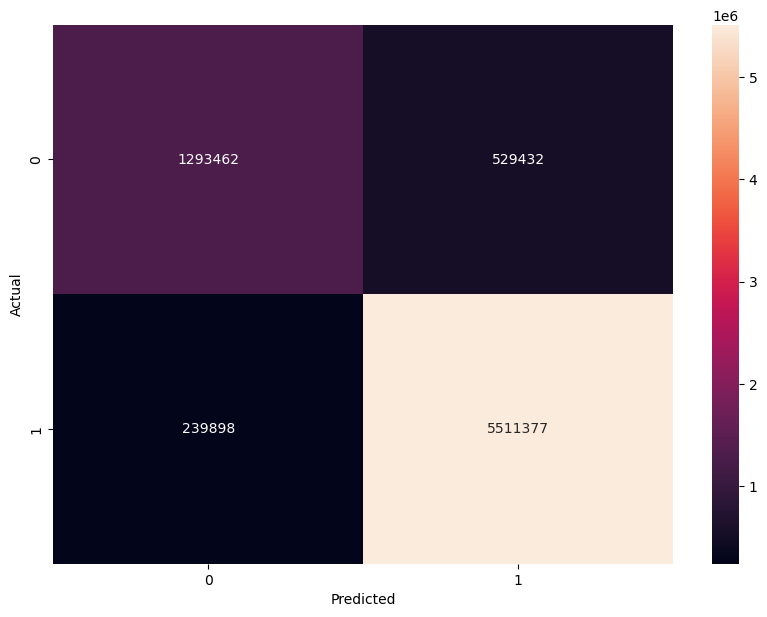

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()